In [11]:
#%pip install torch torchvision
#%pip install opencv-contrib-python
#%pip install scikit-learn
#%pip install matplotlib
#%pip install pandas
#%pip install numpy

In [29]:
# OUR SOURCE : https://blog.paperspace.com/object-localization-pytorch-2/
# Python 3-9

import copy
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import torch
import time
import PIL
from torch import optim
import os
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import optim
import tqdm
import json

In [80]:
df = None
df = pd.read_csv("../labels_peek.csv",sep=";")

# Normalize the values
# alredy done

train, test = train_test_split(df,test_size=0.2)
img_dir = "../image/"


In [81]:
import cv2
def open_images(paths):
        images = []
        for path in paths:
                with PIL.Image.open(img_dir + path) as image:
                        images.append(np.asarray(image))
                
        return np.array(images)


In [82]:
train_img = open_images(train["image"])
test_img = open_images(test["image"])
train_img.shape
test_img.shape

(8, 320, 320)

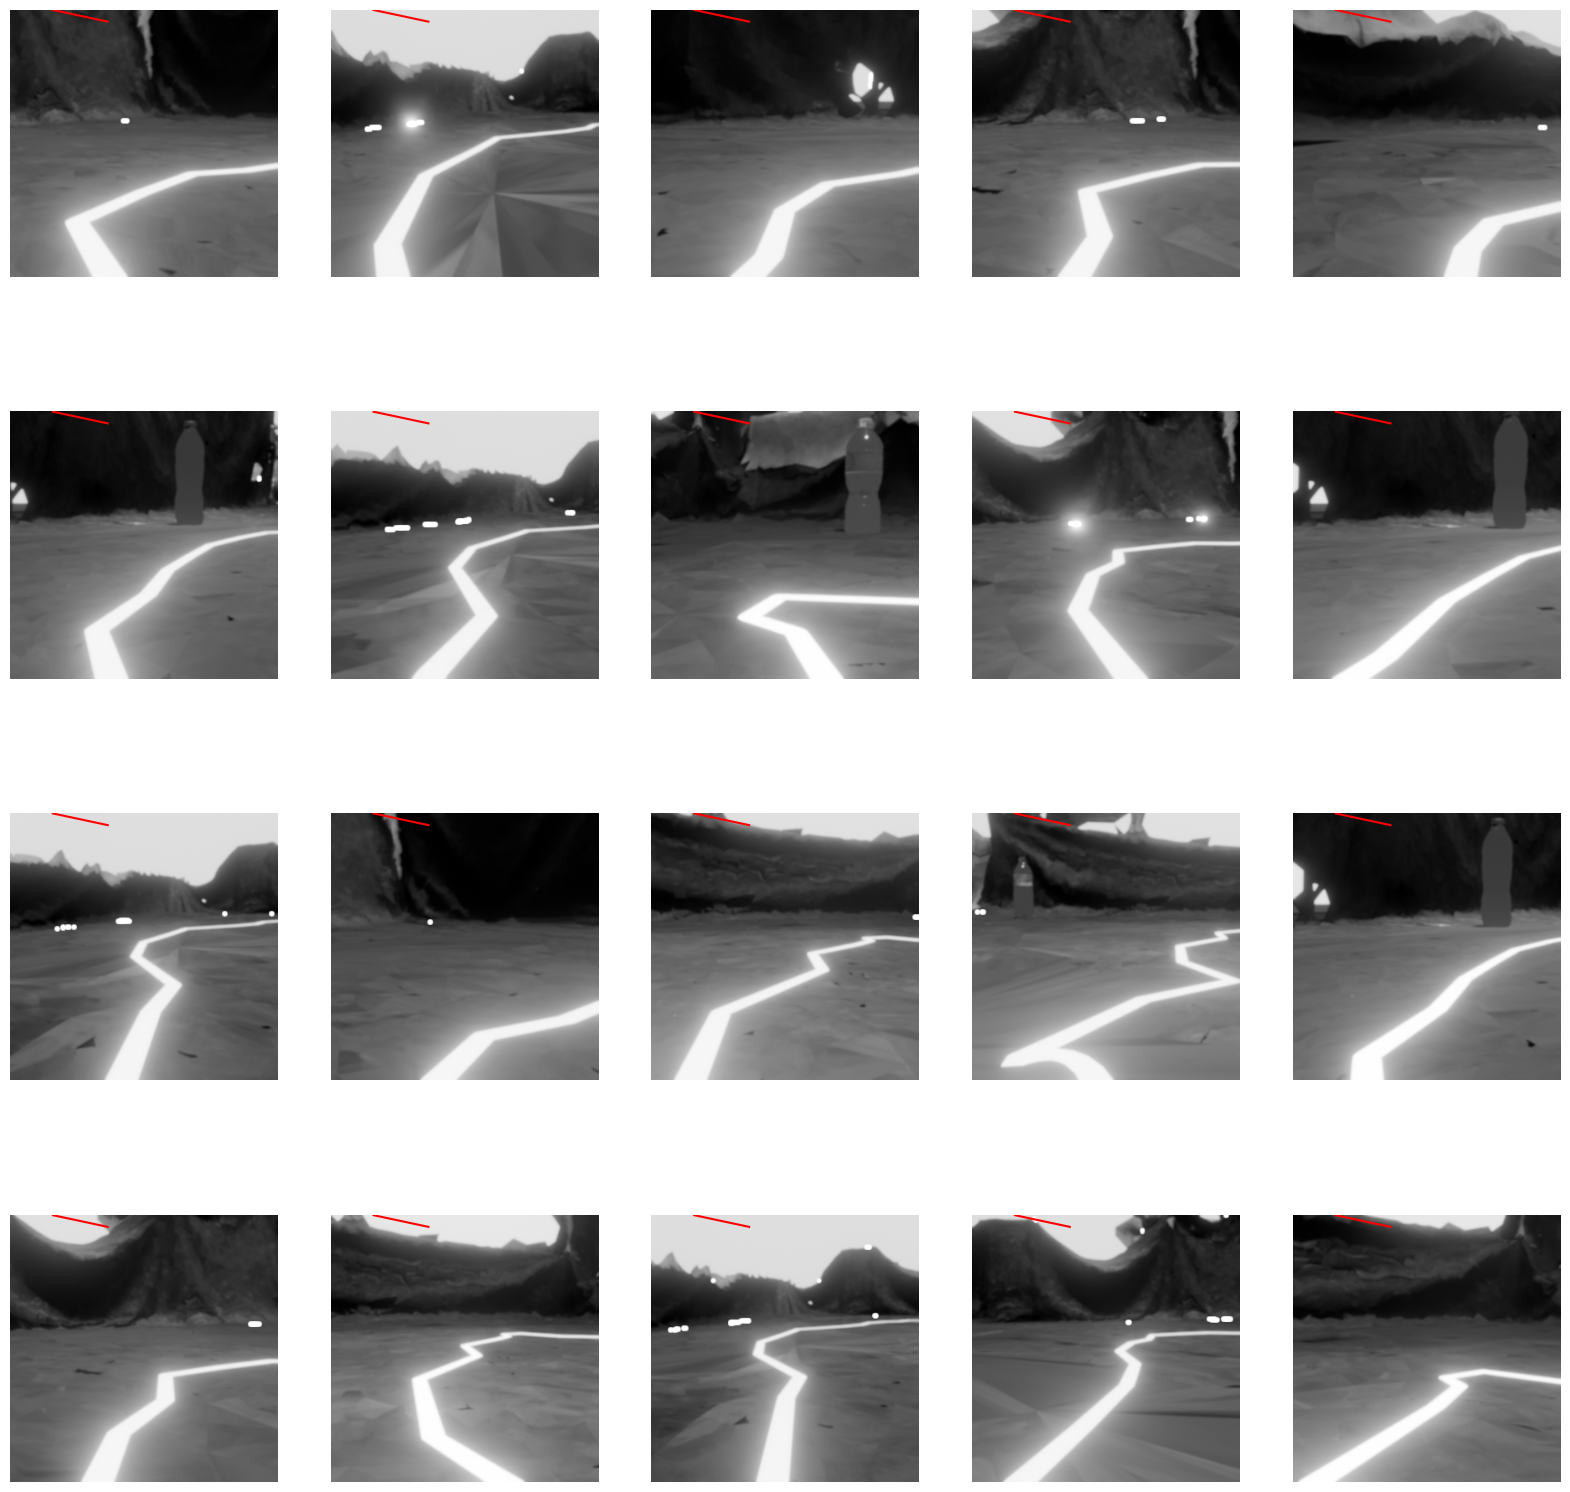

In [104]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
    
    
# Create a Matplotlib figure
plt.figure(figsize=(20,20))

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(train_img)), 20)

for itr, i in enumerate(random_range, 1):
    image = train_img[i]
    
    ax = plt.subplot(4, 5, itr)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
class Dataset():
    def __init__(self, train_images, train_coords):
        self.images = torch.from_numpy(train_images).float()
        self.coords = torch.from_numpy(train_coords).float()

    def __len__(self):
        return len(self.coords)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.coords[idx])

train_coords = train.loc[:,('StartX','StartY','EndX','EndY')].values
test_coords = test.loc[:,('StartX','StartY','EndX','EndY')].values

dataset_train = Dataset(np.expand_dims(train_img,axis=1),train_coords)
dataset_test = Dataset(np.expand_dims(test_img,axis=1),test_coords)

print(dataset_train[0][0].shape)

torch.Size([1, 244, 324])


In [19]:
# OUR MODEL 
class CNN(Module):
    def __init__(self):
        # call the parent constructor
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5)

        self.box_fc1 = nn.Linear(in_features=640, out_features=124)
        self.box_fc2 = nn.Linear(in_features=124, out_features=64)
        self.box_out = nn.Linear(in_features=64, out_features=1)

    def forward(self, t):
        # normalize pixel value
        t = t / 256
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=4, stride=2)

        t = torch.flatten(t,start_dim=-3)
    

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        output = F.sigmoid(box_t)

        return output
model = CNN()
model = model.to(device)
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1))
  (box_fc1): Linear(in_features=640, out_features=124, bias=True)
  (box_fc2): Linear(in_features=124, out_features=64, bias=True)
  (box_out): Linear(in_features=64, out_features=4, bias=True)
)

In [20]:
dataloader = torch.utils.data.DataLoader(
       dataset_train, batch_size=32)
valdataloader = torch.utils.data.DataLoader(
       dataset_test, batch_size=32)

Epoch 1 / 20 ...
Epoch 2 / 20 ...
Epoch 3 / 20 ...
Epoch 4 / 20 ...
Epoch 5 / 20 ...
Epoch 6 / 20 ...
Epoch 7 / 20 ...
Epoch 8 / 20 ...
Epoch 9 / 20 ...
Epoch 10 / 20 ...
Epoch 11 / 20 ...
Epoch 12 / 20 ...
Epoch 13 / 20 ...
Epoch 14 / 20 ...
Epoch 15 / 20 ...
Epoch 16 / 20 ...
Epoch 17 / 20 ...
Epoch 18 / 20 ...
Epoch 19 / 20 ...
Epoch 20 / 20 ...
MSE: 0.00
RMSE: 0.02


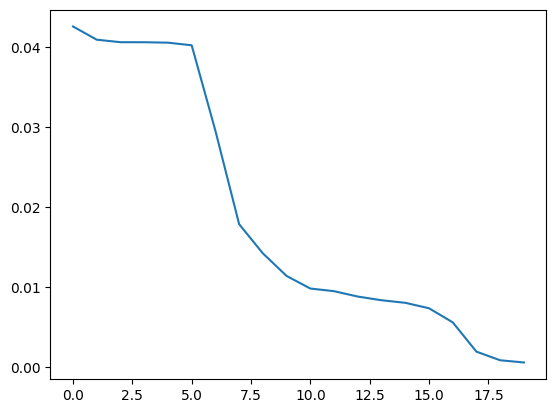

In [21]:
X_train = torch.tensor(np.expand_dims(train_img,axis=1) , dtype=torch.float32)
y_train = torch.tensor(train_coords, dtype=torch.float32)
X_test = torch.tensor(np.expand_dims(test_img,axis=1), dtype=torch.float32)
y_test = torch.tensor(test_coords, dtype=torch.float32)
 
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training parameters
n_epochs = 20  # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    
    # print epoch
    print(f"Epoch {epoch + 1} / {n_epochs} ...")

    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [22]:
def predict(model , image):
    model.eval()
    with torch.no_grad():
        image = torch.from_numpy(np.expand_dims(image,axis=1)).float()
        image = image.to(device)
        outputs = model(image)
        outputs = outputs.cpu().numpy().reshape(4)
    return outputs

def denormalize(coords):   
    coords[0] = coords[0] * 324
    coords[1] = coords[1] * 244
    coords[2] = coords[2] * 324
    coords[3] = coords[3] * 244
    return coords

In [23]:

# OUR PREDICTION
image = test_img[0]
image = np.expand_dims(image, axis=0)  # Reshape the image to have 1 channel

print(image.shape)

pred = predict(model, image)
print(pred)
print(test_coords[0])


(1, 244, 324)
[0.5701104  0.9929885  0.50134516 0.7234187 ]
[0.57407407 0.99590164 0.50617284 0.70081967]


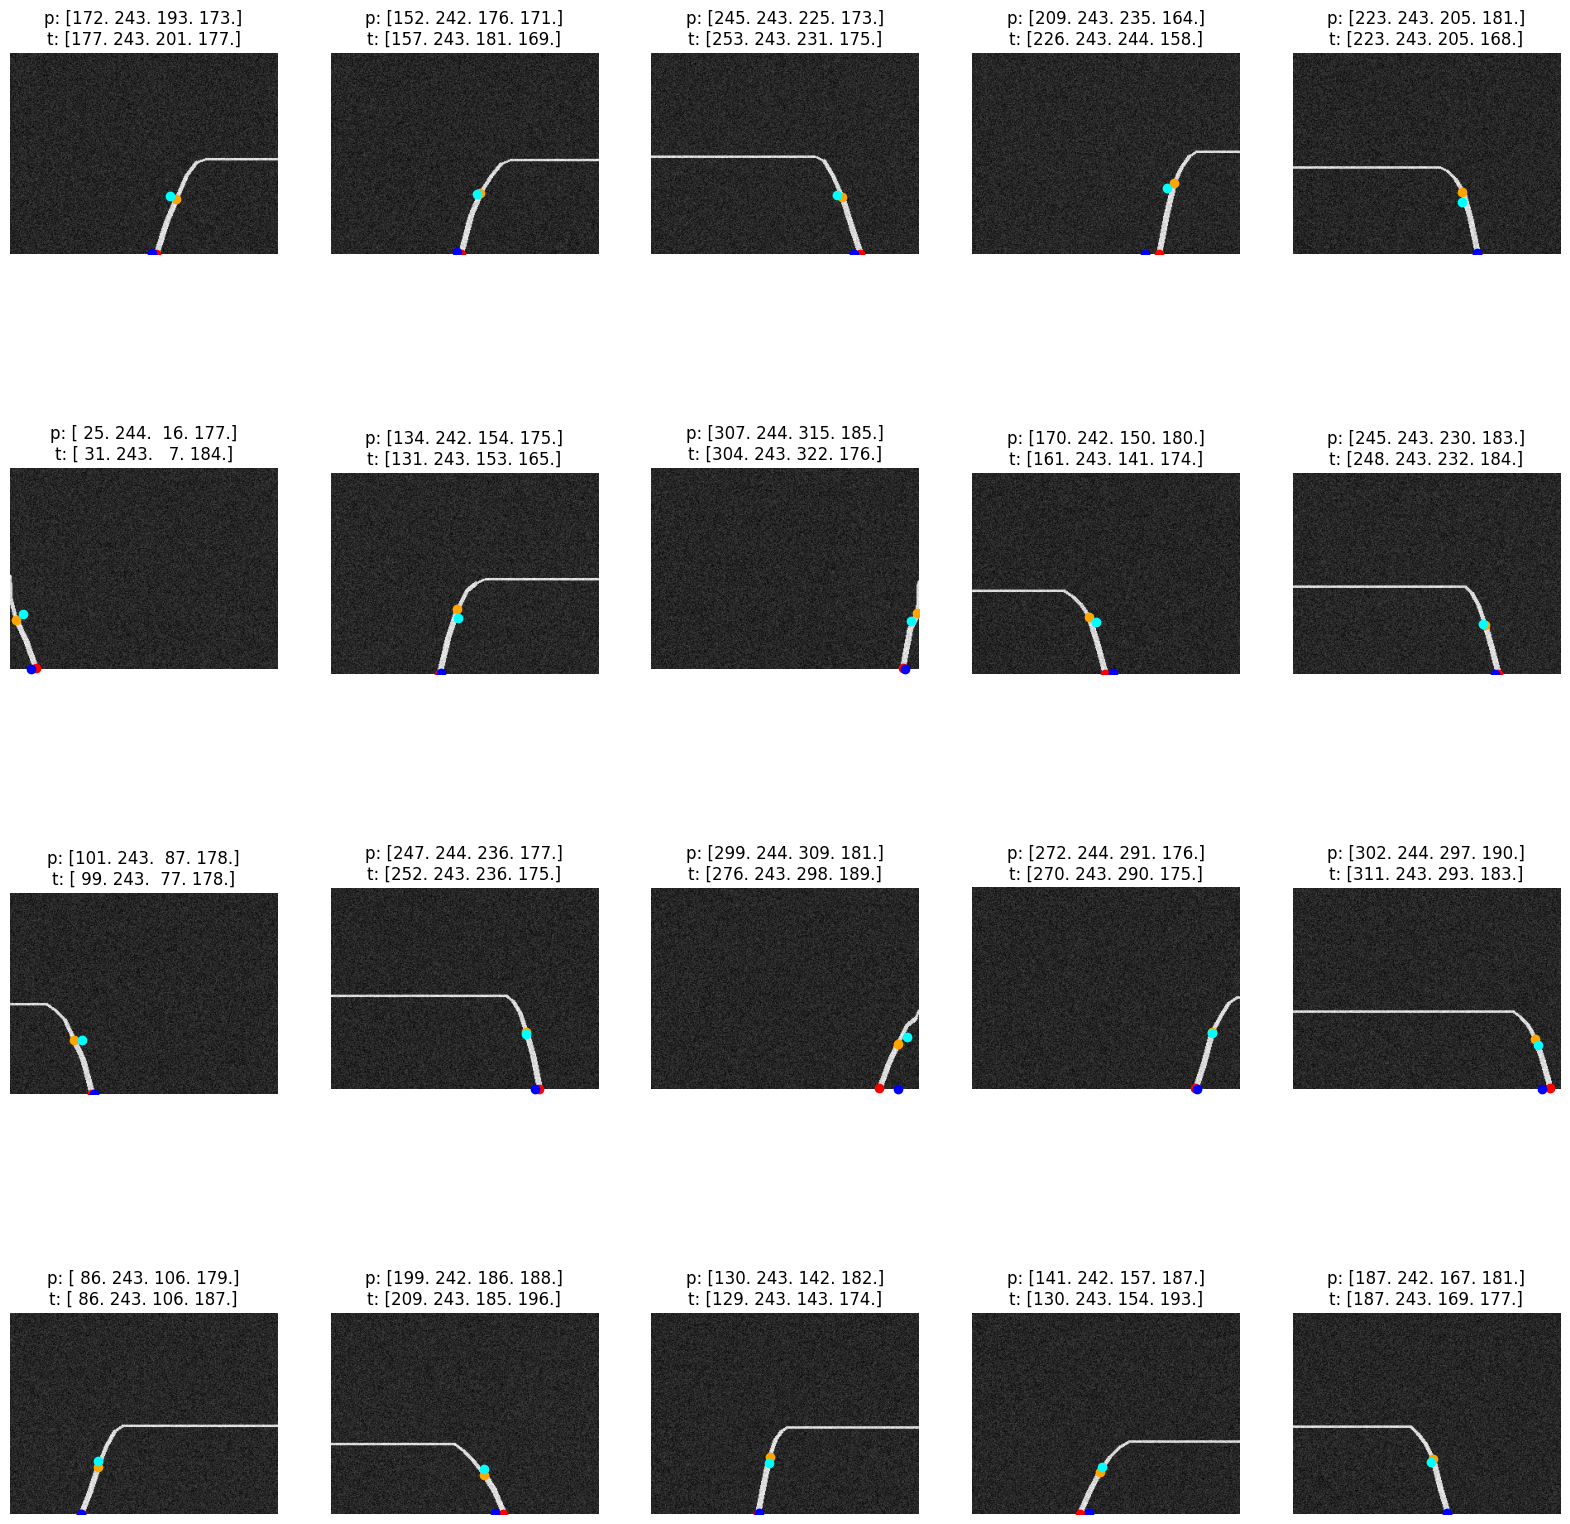

In [24]:
# Generate a random sample of images each time the cell is run
random_range = random.sample(range(1, len(test_img)), 20)

# Create a Matplotlib figure
plt.figure(figsize=(20,20))

for itr, i in enumerate(random_range, 1):
    coords = test_coords[i]
    if coords[0] > 1:
        print(coords)
    coords = denormalize(coords)

    image_reshaped = np.reshape(test_img[i], (1, 244, 324))

    output = predict(model, image_reshaped)
    output = denormalize(output)

    # Clip the values to 0-1 and draw the sample of images
    plt.subplot(4, 5, itr)
    plt.imshow(test_img[i], cmap='gray')
    plt.axis('off')
    plt.title("p: " + str(np.round(output)) + "\nt: " + str(coords))

    # Plot the ground truth points with red variation
    plt.sc

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


In [25]:
torch.save(model.state_dict(), "model.pth")